In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import warnings
import os

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set(style="whitegrid")

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
# Define file paths
# Make sure 'train23.csv' and 'test23.csv' are in the same directory
TRAIN_FILE = '/kaggle/input/hull-tactical-market-prediction/train.csv'
TEST_FILE = '/kaggle/input/hull-tactical-market-prediction/test.csv'

# Load the datasets
try:
    train_df = pd.read_csv(TRAIN_FILE)
    test_df = pd.read_csv(TEST_FILE)

    print("Data loaded successfully.")
    print(f"Train shape: {train_df.shape}")
    print(f"Test shape: {test_df.shape}")

    print("\n--- Train Info ---")
    train_df.info()

    print("\n--- Test Info ---")
    test_df.info()

    print("\n--- Train Head ---")
    print(train_df.head())

    print("\n--- Test Head ---")
    print(test_df.head())

except FileNotFoundError:
    print("Error: train23.csv or test23.csv not found.")
    print("Please ensure the files are in the correct directory.")

Data loaded successfully.
Train shape: (8990, 98)
Test shape: (10, 99)

--- Train Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8990 entries, 0 to 8989
Data columns (total 98 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date_id                        8990 non-null   int64  
 1   D1                             8990 non-null   int64  
 2   D2                             8990 non-null   int64  
 3   D3                             8990 non-null   int64  
 4   D4                             8990 non-null   int64  
 5   D5                             8990 non-null   int64  
 6   D6                             8990 non-null   int64  
 7   D7                             8990 non-null   int64  
 8   D8                             8990 non-null   int64  
 9   D9                             8990 non-null   int64  
 10  E1                             7206 non-null   float64
 11  E10              

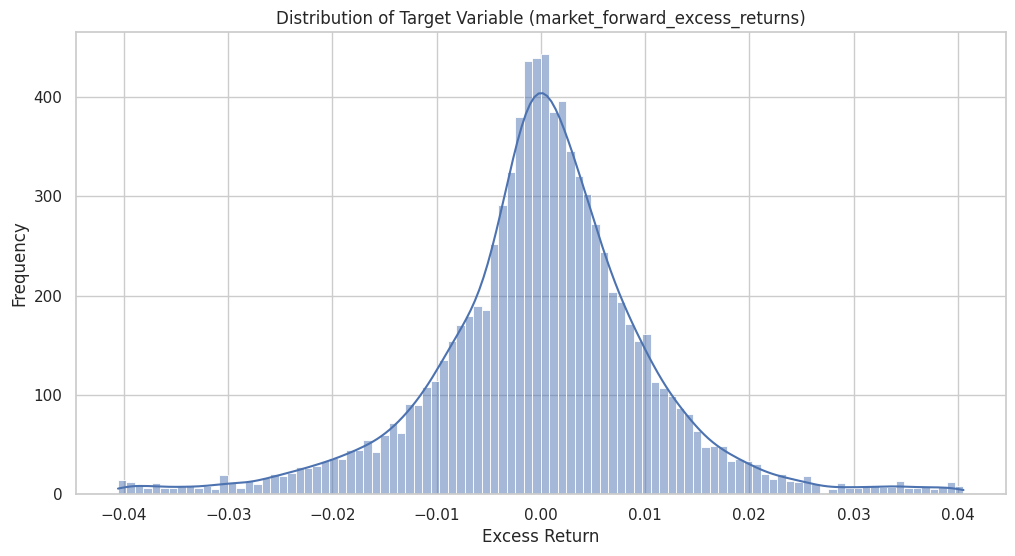

Target variable distribution plot saved as 'target_distribution.png'


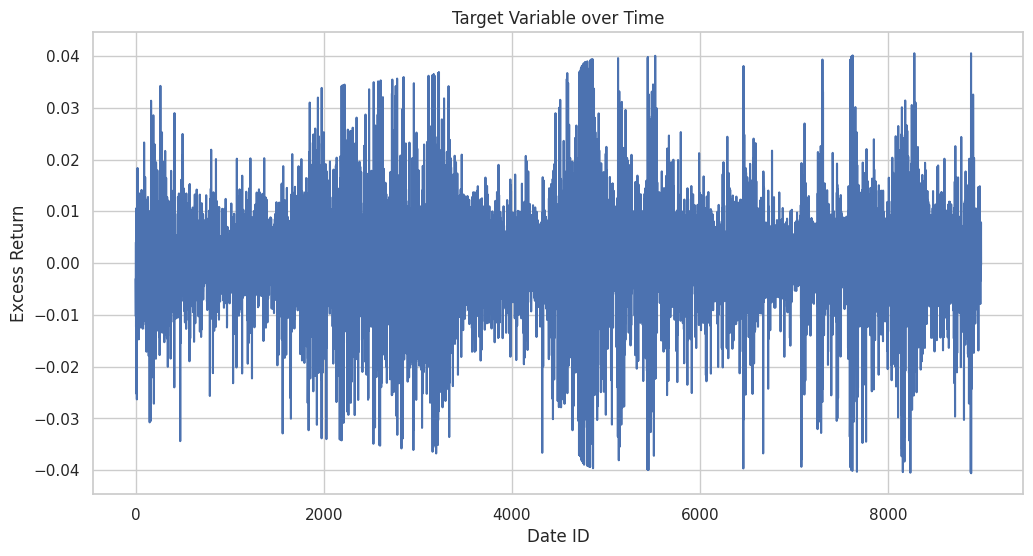

Target variable over time plot saved as 'target_over_time.png'


In [3]:
# Define the target column
TARGET_COL = 'market_forward_excess_returns'

# Check if target column exists
if TARGET_COL in train_df.columns:
    # Plot the distribution of the target variable
    plt.figure(figsize=(12, 6))
    sns.histplot(train_df[TARGET_COL], bins=100, kde=True)
    plt.title('Distribution of Target Variable (market_forward_excess_returns)')
    plt.xlabel('Excess Return')
    plt.ylabel('Frequency')
    plt.savefig('target_distribution.png')
    plt.show()
    plt.close()
    print("Target variable distribution plot saved as 'target_distribution.png'")

    # Plot target variable over time (date_id)
    plt.figure(figsize=(12, 6))
    train_df.set_index('date_id')[TARGET_COL].plot()
    plt.title('Target Variable over Time')
    plt.xlabel('Date ID')
    plt.ylabel('Excess Return')
    plt.savefig('target_over_time.png')
    plt.show()
    plt.close()
    print("Target variable over time plot saved as 'target_over_time.png'")

else:
    print(f"Error: Target column '{TARGET_COL}' not found in training data.")

In [4]:
# Calculate percentage of missing values for each column in train_df
missing_pct = (train_df.isnull().sum() / len(train_df)) * 100
missing_pct = missing_pct.sort_values(ascending=False)

# Plot the top 50 columns with missing data
plt.figure(figsize=(15, 10))
missing_pct.head(50).plot(kind='bar')
plt.title('Top 50 Columns by Percentage of Missing Data (Train Set)')
plt.xlabel('Columns')
plt.ylabel('Percentage Missing (%)')
plt.tight_layout()
plt.savefig('missing_data_barplot.png')
plt.close()
print("Missing data bar plot saved as 'missing_data_barplot.png'")

# Show a summary
print("\nMissing Data Summary (Top 10):")
print(missing_pct.head(10))

Missing data bar plot saved as 'missing_data_barplot.png'

Missing Data Summary (Top 10):
E7     77.519466
V10    67.285873
S3     63.770857
M1     61.701891
M13    61.624027
M14    61.624027
M6     56.095662
V9     50.489433
S12    39.343715
M5     36.518354
dtype: float64


In [5]:
# Create lagged features in the training set
# We shift by 1 to represent the 'lagged' nature
train_df['lagged_forward_returns'] = train_df['forward_returns'].shift(1)
train_df['lagged_risk_free_rate'] = train_df['risk_free_rate'].shift(1)
train_df['lagged_market_forward_excess_returns'] = train_df[TARGET_COL].shift(1)

print("Created lagged features in the training set.")
print(train_df[['forward_returns', 'lagged_forward_returns', TARGET_COL, 'lagged_market_forward_excess_returns']].head())

Created lagged features in the training set.
   forward_returns  lagged_forward_returns  market_forward_excess_returns  \
0        -0.002421                     NaN                      -0.003038   
1        -0.008495               -0.002421                      -0.009114   
2        -0.009624               -0.008495                      -0.010243   
3         0.004662               -0.009624                       0.004046   
4        -0.011686                0.004662                      -0.012301   

   lagged_market_forward_excess_returns  
0                                   NaN  
1                             -0.003038  
2                             -0.009114  
3                             -0.010243  
4                              0.004046  


In [6]:
# Define the feature list from the columns available in the test set
# This ensures we only train on data that will be available at prediction time
FEATURES = [col for col in test_df.columns if col not in ['date_id', 'is_scored']]

# Drop rows in train_df where the target or the new lagged features are NaN
# These rows cannot be used for training
original_rows = len(train_df)
train_df = train_df.dropna(subset=[TARGET_COL] + ['lagged_forward_returns', 'lagged_risk_free_rate', 'lagged_market_forward_excess_returns'])
new_rows = len(train_df)
print(f"Dropped {original_rows - new_rows} rows with NaN in target or lagged features.")

# Define our final X and y
X_train = train_df[FEATURES]
y_train = train_df[TARGET_COL]

print(f"Final training features shape: {X_train.shape}")
print(f"Final training target shape: {y_train.shape}")

Dropped 1 rows with NaN in target or lagged features.
Final training features shape: (8989, 97)
Final training target shape: (8989,)


In [7]:
# Initialize the Imputer
# We use 'mean' strategy as a robust baseline
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training features
print("Fitting imputer on training data...")
imputer.fit(X_train)

# Transform the training data
X_train_imputed = imputer.transform(X_train)
print("Training data imputed.")

# Initialize the LightGBM Regressor
# These are baseline parameters and can be tuned
lgb_model = lgb.LGBMRegressor(
    objective='regression_l1',  # MAE is often more robust to outliers than MSE (L2)
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    reg_alpha=0.1,
    reg_lambda=0.1
)

# Train the model
print("Training LightGBM model...")
lgb_model.fit(X_train_imputed, y_train)

print("Model training complete.")

Fitting imputer on training data...
Training data imputed.
Training LightGBM model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22332
[LightGBM] [Info] Number of data points in the train set: 8989, number of used features: 97
[LightGBM] [Info] Start training from score 0.000253
Model training complete.


In [8]:
# This scaling factor is a key hyperparameter you would tune
# It controls how sensitive your allocation is to the predicted return
SCALING_FACTOR = 100 

def get_allocation(predicted_returns, scaling_factor=SCALING_FACTOR):
    """
    Converts predicted returns into an allocation strategy.
    """
    # Start with a neutral allocation
    allocations = 1.0 + predicted_returns * scaling_factor
    
    # Clip the allocations to be within the allowed [0, 2] range
    clipped_allocations = np.clip(allocations, 0.0, 2.0)
    
    return clipped_allocations

print("Betting strategy function 'get_allocation' defined.")

Betting strategy function 'get_allocation' defined.


In [9]:
print("Generating mock submission file...")

# Get features from the mock test set
X_test_mock = test_df[FEATURES]

# Impute missing values using the *trained* imputer
X_test_mock_imputed = imputer.transform(X_test_mock)

# Predict returns
predicted_returns_mock = lgb_model.predict(X_test_mock_imputed)

# Convert predictions to allocations
allocations_mock = get_allocation(predicted_returns_mock, scaling_factor=SCALING_FACTOR)

# Create submission DataFrame
submission_df = pd.DataFrame({
    'date_id': test_df['date_id'],
    'allocation': allocations_mock
})

# Save to submission.csv
submission_df.to_csv('submission.csv', index=False)

print("Mock 'submission.csv' created successfully.")
print(submission_df.head())

Generating mock submission file...
Mock 'submission.csv' created successfully.
   date_id  allocation
0     8980    0.871575
1     8981    0.858492
2     8982    1.511049
3     8983    1.091603
4     8984    0.932971


In [10]:
# This cell is for the official submission and will only run in the Kaggle environment
# Attempt to import the evaluation API
try:
    import kaggle_evaluation
    
    print("kaggle_evaluation API imported. Preparing for live submission...")

    # Set up the environment
    env = kaggle_evaluation.make_env()
    
    # Get the iterator for the test set
    iter_test = env.iter_test()
    
    # Loop through each day in the test set
    for (test_df_live, lagged_df_live, sample_prediction_df) in iter_test:
        
        # Extract features (test_df_live already has the lagged features)
        X_live = test_df_live[FEATURES]
        
        # Impute missing values
        X_live_imputed = imputer.transform(X_live)
        
        # Predict returns (returns a 1-element array)
        pred_returns_live = lgb_model.predict(X_live_imputed)
        
        # Get allocation (returns a 1-element array)
        allocation_live = get_allocation(pred_returns_live, scaling_factor=SCALING_FACTOR)
        
        # Set the allocation in the sample prediction DataFrame
        sample_prediction_df['allocation'] = allocation_live[0]
        
        # Submit the prediction for this day
        env.predict(sample_prediction_df)
        
        # print(f"Submitted allocation {allocation_live[0]:.4f} for date_id {test_df_live['date_id'].values[0]}")

    print("Official submission loop complete.")

except ImportError:
    print("\nWARNING: 'kaggle_evaluation' not found.")
    print("This is expected outside the Kagg/le submission environment.")
    print("Cell 10 is designed for the official competition submission.")
except Exception as e:
    print(f"An error occurred during the API submission loop: {e}")

kaggle_evaluation API imported. Preparing for live submission...
An error occurred during the API submission loop: module 'kaggle_evaluation' has no attribute 'make_env'
